In [22]:
import re
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from random import randint
from matplotlib.ticker import MaxNLocator
from functools import partial
import pickle
import ast

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn import decomposition, ensemble

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse

import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import string
from nltk.corpus import stopwords
punctuation_without_dot = list(filter(lambda x: x != '.' or x != ',' , string.punctuation))
STOPWORDS = list(set(stopwords.words('english'))) + punctuation_without_dot
#WARNING ! ! ! 
#There are several known issues with ‘english’ and you should consider an alternative.
#-> https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words

import data_lake_helper as dl_helper

In [23]:
data_lake = dl_helper.DataLake(version='v3')

In [24]:
def load_feature(feature, load_version=None):

    if load_version is None:
        data_lake_ = data_lake
    else:
        data_lake_ = DataLake(version=load_version)
    
    df[feature] = data_lake_.load_obj(feature + '.pkl')

In [25]:
#setting up dataframe 

df_train_table = pd.read_csv('../../source/dataset/train_set.csv')
df_train_table.index = df_train_table.pk_id
df_train_table['path'] = 'source/dataset/train_set/'
del df_train_table['pk_id']

df_test_table = pd.read_csv('../../source/dataset/test_set.csv')
df_test_table.index = df_test_table.pk_id
df_test_table['path'] = 'source/dataset/test_set/'
del df_test_table['pk_id']

df = df_train_table.append(df_test_table, sort=False)

del df['master_tree']

In [134]:
class Feature:
    
    def __init__(self):
        self.values = []
        self.name = ''
    
    def transform(self, text):
        pass

In [135]:
class Length(Feature):
    def __init__(self):
        self.name = 'letter_lenght'
        self.values = []
    
    def transform(self, text):
        return len(text)

In [136]:
class Word_Count(Feature):
    def __init__(self):
        self.name = 'word_count'
        self.values = []
    
    def transform(self, text):
        return len(text.split())

In [137]:
enumeration_regex = "\n[0-9]{1,2}[.]\s[a-zA-Z]"
enumeration_regex_2 = "\n[0-9]{1,2}[.]"

class Enum_Presence(Feature):
    def __init__(self):
        self.name = 'enumeration_presence'
        self.values = []
    
    def transform(self, text):
        enums = re.findall(enumeration_regex, text)
        enums_len = len(enums)
        return enums_len > 0

In [138]:
class Enum_Count(Feature):
    def __init__(self):
        self.name = 'enumeration_count'
        self.values = []
    
    def transform(self, text):
        enums = re.findall(enumeration_regex, text)
        enums_len = len(enums)
        return enums_len

In [139]:
class Enum_Repeated(Feature):
    def __init__(self):
        self.name = 'enumeration_repeated'
        self.values = []
    
    def transform(self, text):
        enums = re.findall(enumeration_regex, text)
        enums = re.findall(enumeration_regex_2, ' '.join(enums))
        
        unique_enums = list(set(enums))
        has_repeated_enums = not len(unique_enums) == len(enums)
        return has_repeated_enums

In [140]:
def look_for_text_list(text_list, text):
    text = text.lower()
    has_text = False
    for text_to_look_for in text_list:
        has_text = (text_to_look_for in text) or has_text
    return has_text

In [141]:
#SEC letters classification
################################

class SEC_Header(Feature):
    def __init__(self):
        self.name = 'sec_header_presence'
        self.values = []
        
        header_sentence_1 = 'UNITED STATES SECURITIES AND EXCHANGE COMMISSION'.lower()
        header_sentence_2 = 'WASHINGTON, D.C. 20549-4628'.lower()
        header_sentence_3 = 'DIVISION OF CORPORATION FINANCE'.lower()
        self.sec_headers = [header_sentence_1, header_sentence_2, header_sentence_3]
        self.sec_headers = ' '.join(sec_headers)

        self.look_for_sec_headers = partial(look_for_text_list, sec_headers)
    
    def transform(self, text):
        return look_for_sec_headers(text)

In [142]:
#Response letters classification
################################

class Response_Text(Feature):
    def __init__(self):
        self.name = 'response_presence'
        self.values = []
        
        rl_sentence_2 = 'response :'.lower()
        rl_sentence_4 = 'responses :'.lower()
        rl_headers = [rl_sentence_2, rl_sentence_4]
        self.look_for_rl_headers = partial(look_for_text_list, rl_headers)
    
    def transform(self, text):
        return look_for_rl_headers(text)

In [143]:
#Comment letters classification
################################

class Comment_Text(Feature):
    def __init__(self):
        self.name = 'cl_sentence_presence'
        self.values = []
        
        cl_sentence_1 = 'We have reviewed your filing and have the following comments.'.lower()
        cl_sentence_2 = 'After reviewing your response to these comments, we may have additional comments.'.lower()
        cl_headers = [cl_sentence_1, cl_sentence_2]

        self.look_for_cl_headers = partial(look_for_text_list, cl_headers)
    
    def transform(self, text):
        return look_for_cl_headers(text)

# Extracting features !

In [144]:
file_extension = '.txt'

features = [Length(), 
            Word_Count(),
            Enum_Presence(),
            Enum_Count(),
            Enum_Repeated(),
            SEC_Header(),
            Response_Text(),
            Comment_Text()]

texts = []
for i in range(0,len(df)):
    item = df.iloc[i]
    pk_id = str(item.name)
    text = open(item.path + pk_id + file_extension).read()
    texts.append(text)
    
    #getting each feature from every text item
    for feature in features:
        t = feature.transform(text)
        feature.values.append(t)    

#saving each feature as a pandas series
for feature in features:
    df[feature.name] = feature.values
    feature_as_serie = df[feature.name]
    data_lake.save_obj(feature_as_serie, feature.name + '.pkl')
    del df[feature.name]

In [145]:
#getting word_density feature here!
#
letter_lenght = data_lake.load_obj(Length().name + '.pkl')
word_count = data_lake.load_obj(Word_Count().name + '.pkl')
word_density = letter_lenght/(word_count+1)

data_lake.save_obj(word_density, 'word_density.pkl')

In [155]:
#just checking...

for f in features:
    print(f.name, len(data_lake.load_obj(f.name + '.pkl')))

print('df', len(df))

letter_lenght 55556
word_count 55556
enumeration_presence 55556
enumeration_count 55556
enumeration_repeated 55556
sec_header_presence 55556
response_presence 55556
cl_sentence_presence 55556
df 55556


# Pipelines 

In [158]:
class TextToLower(TransformerMixin, BaseEstimator):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        return [text.lower() for text in texts]
        
class TextWithOutStopWords(TransformerMixin, BaseEstimator):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        texts_ = []
        for text in texts:
            text = text.replace('\n', ' ')
            text = " ".join([i for i in word_tokenize(text) if i not in STOPWORDS])
            texts_.append(text)
        
        return texts_

class TextWithOutNonASCII(TransformerMixin, BaseEstimator):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        texts_ = []
        for text in texts:
            text = text.encode("ascii", "ignore").decode()
            texts_.append(text)
        
        return texts_
    
ps = PorterStemmer() 
class TextStemming(TransformerMixin, BaseEstimator):
    def fit(self, x, y=None):
        return self
    def transform(self, texts):
        texts_ = []
        for text in texts:
            tokenized_words = word_tokenize(text)
            for i, w in enumerate(tokenized_words):
                tokenized_words[i] = ps.stem(w)
                text = ' '.join(tokenized_words)
            
            texts_.append(text)
        
        return texts_

In [169]:
pipeline = Pipeline([
    ("T_to_L", TextToLower()),
    ("T_no_SW", TextWithOutStopWords()),
    ("T_no_ascii", TextWithOutNonASCII()),
    ("TS", TextStemming())#PROBAR TMB CON Lemmatization !!!
    ])
    
f_name = 'text_normalized'
texts_t = pipeline.transform(texts)

df[f_name] = texts_t
data_lake.save_obj(df[f_name], f_name + '.pkl')
del df[f_name]


AttributeError: 'DataLake' object has no attribute 'save_object'

# Data cleaning 

In [26]:
load_feature('letter_lenght')

Text(0.5, 1.0, 'letter_lenght distribution')

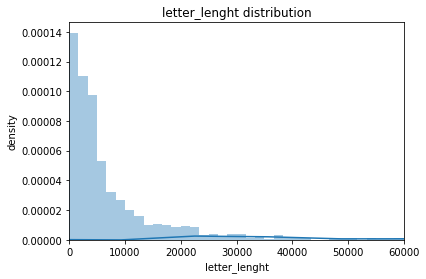

In [16]:
sns.distplot(df.letter_lenght, bins = 1000)
plt.xlim(0, 60000)
plt.ylabel('density')
plt.title('letter_lenght distribution')

In [7]:
threshold = 35000
msg = "df_.letter_lenght > " + str(threshold) + " =>"
print(msg, round(len(df[df.letter_lenght > threshold]) / len(df) * 100, 2))
print(msg, df[df.letter_lenght > threshold].category.unique())

df_.letter_lenght > 35000 => 4.18
df_.letter_lenght > 35000 => ['RL' 'UU']


In [8]:
#removing outliers
df = df[df.letter_lenght < threshold]

In [27]:
df_train_table = df[df.path == 'source/dataset/train_set/']
df_test_table = df[df.path == 'source/dataset/test_set/']

In [28]:
# SHOULD REMOVE ACAK CATEGORY !!!
#

train_categories = df_train_table.category.unique()
test_categories = df_test_table.category.unique()

if len(train_categories) < len(test_categories):
    print('categorias que no se puede entrenar:')
    cat_to_remove = [c for c in test_categories if c not in train_categories]
    print(cat_to_remove)

    #removing categories that are not in the train data set
    for c in cat_to_remove:
        df = df[df.category != c]
        df_train_table = df[df.path == 'source/dataset/train_set/']
        df_test_table = df[df.path == 'source/dataset/test_set/']
else:
    print('train & test dataset presentan las mismas categorias')

train & test dataset presentan las mismas categorias


In [29]:
del df['letter_lenght']

In [30]:
# saving cleaned dataframe !!
#

df.to_csv('../../source/features/v3/df-cleaned.csv')
#data_lake.save_obj(df, 'df-cleaned.pkl')

# Feature vectors

In [222]:
load_feature(f_name)
train_x = df[df.path == 'source/dataset/train_set/'][f_name]
valid_x = df[df.path == 'source/dataset/test_set/'][f_name]

In [223]:
# Count Vectors as features
########################################

print("fitting CountVectorizer...")
time_start = time.time()

config = data_lake.load_config('count_vect_config.txt')

# create a count vectorizer object 
count_vect = CountVectorizer(analyzer=config['analyzer'],
                             token_pattern=config['token_pattern'],
                             ngram_range=config['ngram_range'])
count_vect.fit(df[f_name])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

#saving matrices
data_lake.save_npz(xvalid_count, "xvalid_count.npz")
data_lake.save_npz(xtrain_count, "xtrain_count.npz")
data_lake.save_obj(count_vect, "count_vect.pkl")

print("fitting finished - time: ", time.time() - time_start)
print()

fitting CountVectorizer...
fitting finished - time:  124.39757490158081



In [224]:
# word level tf-idf
###################

print("fitting word level tf-idf...")
time_start = time.time()

config = data_lake.load_config('tf_idf_word_vect_config.txt')

#TODO: probar otros valores para max_features, 1D uso 50.000
tfidf_vect = TfidfVectorizer(analyzer=config['analyzer'],
                             token_pattern=config['token_pattern'],
                             max_features=config['max_features'])
tfidf_vect.fit(df[f_name])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

#saving matrices
data_lake.save_npz(xvalid_tfidf, "xvalid_tfidf.npz")
data_lake.save_npz(xtrain_tfidf, "xtrain_tfidf.npz")

print("fitting finished - time: ", time.time() - time_start)
print()

fitting word level tf-idf...
fitting finished - time:  47.41982913017273



In [225]:
# n-gram level tf-idf 
####################

print("fitting ngram level tf-idf...")
time_start = time.time()

config = data_lake.load_config('tf_idf_n_gram_vect_config.txt')

#TODO: probar otros valores para max_features, 1D uso 50.000
tfidf_vect_ngram = TfidfVectorizer(analyzer=config['analyzer'],
                                   token_pattern=config['token_pattern'],
                                   ngram_range=config['ngram_range'],
                                   max_features=config['max_features'])
tfidf_vect_ngram.fit(df[f_name])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

#saving matrices
data_lake.save_npz(xvalid_tfidf_ngram, "xvalid_tfidf_ngram.npz")
data_lake.save_npz(xtrain_tfidf_ngram, "xtrain_tfidf_ngram.npz")
data_lake.save_obj(tfidf_vect_ngram, "tfidf_vect_ngram.pkl")

print("fitting finished - time: ", time.time() - time_start)
print()

fitting ngram level tf-idf...
fitting finished - time:  246.00837469100952



In [226]:
# characters level tf-idf
#########################

print("fitting characters level tf-idf...")
time_start = time.time()

config = data_lake.load_config('tf_idf_char_vect_config.txt')

#TODO: probar otros valores para max_features, 1D uso 50.000
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer=config['analyzer'],
                                         token_pattern=config['token_pattern'],
                                         ngram_range=config['ngram_range'],
                                         max_features=config['max_features'])
tfidf_vect_ngram_chars.fit(df[f_name])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

#saving matrices
data_lake.save_npz(xvalid_tfidf_ngram_chars, "xvalid_tfidf_ngram_chars" + ".npz")
data_lake.save_npz(xtrain_tfidf_ngram_chars, "xtrain_tfidf_ngram_chars" + ".npz")

print("fitting finished - time: ", time.time() - time_start)
print()

fitting characters level tf-idf...


//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


fitting finished - time:  443.69289684295654



In [227]:
#Topic Models as features
####################################

print("training LDA Model...")
time_start = time.time()

config = data_lake.load_config('lda_config.txt')

# train a LDA Model
#TODO: SHOULD TRY VALUES FOR n_components !!!
lda_model = decomposition.LatentDirichletAllocation(n_components=config['n_components'],
                                                    learning_method=config['learning_method'],
                                                    max_iter=config['max_iter'])
X_topics = lda_model.fit_transform(xtrain_tfidf_ngram)

data_lake.save_obj(X_topics, 'X_topics' + '.pkl')
data_lake.save_obj(lda_model, 'lda_model' + '.pkl')

print("training finished - time: ", time.time() - time_start)
print()

training LDA Model...
training finished - time:  899.3639438152313

